In [1]:
# import getpass
# from oauth2client.client import GoogleCredentials
# from google.colab import auth
# !apt-get install - y - qq software-properties-common python-software-properties module-init-tools
# !add-apt-repository - y ppa: alessandro-strada/ppa 2 > &1 > /dev/null
# !apt-get update - qq 2 > &1 > /dev/null
# !apt-get - y install - qq google-drive-ocamlfuse fuse
# auth.authenticate_user()
# creds = GoogleCredentials.get_application_default()
# !google-drive-ocamlfuse - headless - id = {creds.client_id} - secret = {creds.client_secret} < /dev/null 2 > &1 | grep URL
# vcode = getpass.getpass()
# !echo {vcode} | google-drive-ocamlfuse - headless - id = {creds.client_id} - secret = {creds.client_secret}

In [2]:
# !mkdir - p drive
# !google-drive-ocamlfuse drive - o nonempty

In [3]:
# import os
# os.chdir('drive')

In [4]:
# !ls Competitions/KDD-Cup-2019-CAMMTR/Data

In [93]:
import ast
from itertools import product

from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.metrics import accuracy_score

import json
from tqdm import tqdm
import warnings
import numpy as np
import pandas as pd
import lightgbm as lgb
import os

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

warnings.filterwarnings("ignore")

# project_path='./Competitions/KDD-Cup-2019-CAMMTR/'
project_path = '../../'

holidays = pd.Series(
    json.load(open(project_path+r'Config/Holidays.json'))['holidays'])
subwayinfo = pd.read_csv(project_path+r'Data/Beijing.csv')
weatherinfo =pd.read_csv(project_path+r'Data/Weather.csv')

# Feature engineering

In [95]:
def load_data(mainpath):
    train_queries = pd.read_csv(
        mainpath + 'train_queries.csv', parse_dates=['req_time'])
    train_plans = pd.read_csv(mainpath + 'train_plans.csv',
                              parse_dates=['plan_time'])
    train_clicks = pd.read_csv(mainpath + 'train_clicks.csv')
#     profiles = pd.read_csv(mainpath + 'profiles.csv')
    test_queries = pd.read_csv(
        mainpath + 'test_queries.csv', parse_dates=['req_time'])
    test_plans = pd.read_csv(mainpath + 'test_plans.csv',
                             parse_dates=['plan_time'])
    return train_queries, train_plans, train_clicks, test_queries, test_plans

In [96]:
def read_profile_data():
    profile_data = pd.read_csv(mainpath + 'profiles.csv')
    profile_na = np.zeros(67)
    profile_na[0] = -1
    profile_na = pd.DataFrame(profile_na.reshape(1, -1))
    profile_na.columns = profile_data.columns
    profile_data = profile_data.append(profile_na)
    return profile_data

In [97]:
def merge(train_queries, train_plans, train_clicks, test_queries, test_plans):
    train = train_queries.merge(train_plans, 'left', ['sid'])
    test = test_queries.merge(test_plans, 'left', ['sid'])
    train = train.merge(train_clicks, 'left', ['sid'])
    train['click_mode'] = train['click_mode'].fillna(0).astype(int)
    data = pd.concat([train, test], ignore_index=True)
#     data = data.merge(profiles, 'left', ['pid'])
    return train, test, data

In [98]:
def gen_plan_feas(data):
    n = data.shape[0]
    mode_list_feas = np.zeros((n, 12))
    max_dist, min_dist, mean_dist, std_dist = np.zeros(
        (n,)), np.zeros((n,)), np.zeros((n,)), np.zeros((n,))

    max_price, min_price, mean_price, std_price = np.zeros(
        (n,)), np.zeros((n,)), np.zeros((n,)), np.zeros((n,))

    max_eta, min_eta, mean_eta, std_eta = np.zeros(
        (n,)), np.zeros((n,)), np.zeros((n,)), np.zeros((n,))

    min_dist_mode, max_dist_mode, min_price_mode, max_price_mode, min_eta_mode, max_eta_mode, first_mode = \
        np.zeros((n,)), np.zeros((n,)), np.zeros((n,)), np.zeros(
            (n,)), np.zeros((n,)), np.zeros((n,)), np.zeros((n,))

    mode_texts = []
    for i, plan in tqdm(enumerate(data['plans_json'].values)):
        if len(plan) == 0:
            cur_plan_list = []
        else:
            cur_plan_list = plan
        if len(cur_plan_list) == 0:
            mode_list_feas[i, 0] = 1
            first_mode[i] = 0
            max_dist[i] = -1
            min_dist[i] = -1
            mean_dist[i] = -1
            std_dist[i] = -1
            max_price[i] = -1
            min_price[i] = -1
            mean_price[i] = -1
            std_price[i] = -1
            max_eta[i] = -1
            min_eta[i] = -1
            mean_eta[i] = -1
            std_eta[i] = -1
            min_dist_mode[i] = -1
            max_dist_mode[i] = -1
            min_price_mode[i] = -1
            max_price_mode[i] = -1
            min_eta_mode[i] = -1
            max_eta_mode[i] = -1
            mode_texts.append('word_null')
        else:
            distance_list = []
            price_list = []
            eta_list = []
            mode_list = []
            for tmp_dit in cur_plan_list:
                distance_list.append(int(tmp_dit['distance']))
                if tmp_dit['price'] == '':
                    price_list.append(0)
                else:
                    price_list.append(int(tmp_dit['price']))
                eta_list.append(int(tmp_dit['eta']))
                mode_list.append(int(tmp_dit['transport_mode']))
            mode_texts.append(
                ' '.join(['word_{}'.format(mode) for mode in mode_list]))
            distance_list = np.array(distance_list)
            price_list = np.array(price_list)
            eta_list = np.array(eta_list)
            mode_list = np.array(mode_list, dtype='int')
            mode_list_feas[i, mode_list] = 1
            distance_sort_idx = np.argsort(distance_list)
            price_sort_idx = np.argsort(price_list)
            eta_sort_idx = np.argsort(eta_list)
            max_dist[i] = distance_list[distance_sort_idx[-1]]
            min_dist[i] = distance_list[distance_sort_idx[0]]
            mean_dist[i] = np.mean(distance_list)
            std_dist[i] = np.std(distance_list)
            max_price[i] = price_list[price_sort_idx[-1]]
            min_price[i] = price_list[price_sort_idx[0]]
            mean_price[i] = np.mean(price_list)
            std_price[i] = np.std(price_list)
            max_eta[i] = eta_list[eta_sort_idx[-1]]
            min_eta[i] = eta_list[eta_sort_idx[0]]
            mean_eta[i] = np.mean(eta_list)
            std_eta[i] = np.std(eta_list)
            first_mode[i] = mode_list[0]
            max_dist_mode[i] = mode_list[distance_sort_idx[-1]]
            min_dist_mode[i] = mode_list[distance_sort_idx[0]]
            max_price_mode[i] = mode_list[price_sort_idx[-1]]
            min_price_mode[i] = mode_list[price_sort_idx[0]]
            max_eta_mode[i] = mode_list[eta_sort_idx[-1]]
            min_eta_mode[i] = mode_list[eta_sort_idx[0]]
    feature_data = pd.DataFrame(mode_list_feas)
    feature_data.columns = ['mode_feas_{}'.format(i) for i in range(12)]
    feature_data['max_dist'] = max_dist
    feature_data['min_dist'] = min_dist
    feature_data['mean_dist'] = mean_dist
    feature_data['std_dist'] = std_dist
    feature_data['max_price'] = max_price
    feature_data['min_price'] = min_price
    feature_data['mean_price'] = mean_price
    feature_data['std_price'] = std_price
    feature_data['max_eta'] = max_eta
    feature_data['min_eta'] = min_eta
    feature_data['mean_eta'] = mean_eta
    feature_data['std_eta'] = std_eta
    feature_data['max_dist_mode'] = max_dist_mode
    feature_data['min_dist_mode'] = min_dist_mode
    feature_data['max_price_mode'] = max_price_mode
    feature_data['min_price_mode'] = min_price_mode
    feature_data['max_eta_mode'] = max_eta_mode
    feature_data['min_eta_mode'] = min_eta_mode
    feature_data['first_mode'] = first_mode
    print('mode tfidf...')
    tfidf_enc = TfidfVectorizer(ngram_range=(1, 2))
    tfidf_vec = tfidf_enc.fit_transform(mode_texts)
    svd_enc = TruncatedSVD(n_components=10, n_iter=20, random_state=2019)
    mode_svd = svd_enc.fit_transform(tfidf_vec)
    mode_svd = pd.DataFrame(mode_svd)
    mode_svd.columns = ['svd_mode_{}'.format(i) for i in range(10)]
    plan_fea = pd.concat([feature_data, mode_svd], axis=1)
    plan_fea['sid'] = data['sid'].values

    return plan_fea

In [99]:
def gen_profile_feas(data):
    profile_data = read_profile_data()
    x = profile_data.drop(['pid'], axis=1).values
    svd = TruncatedSVD(n_components=20, n_iter=20, random_state=2019)
    svd_x = svd.fit_transform(x)
    svd_feas = pd.DataFrame(svd_x)
    svd_feas.columns = ['svd_fea_{}'.format(i) for i in range(20)]
    svd_feas['pid'] = profile_data['pid'].values
    data['pid'] = data['pid'].fillna(-1)
    data = data.merge(svd_feas, on='pid', how='left')
    return data

In [100]:
mainpath = project_path + r'Data/data_set_phase1/'

In [101]:
train_queries, train_plans, train_clicks, test_queries, test_plans = load_data(
    mainpath)

In [111]:
train, test, data = merge(train_queries, train_plans,
                          train_clicks, test_queries, test_plans)

In [112]:
data=gen_profile_feas(data)

In [113]:
def feature_engineering(df):
    df['time_diff'] = df['plan_time'].astype(
        int) - df['req_time'].astype(int)

    df['plans_json'] = data['plans'].fillna(
        '[]').apply(lambda x: json.loads(x))
    df_plans = gen_plan_feas(df)
    plan_features = [col for col in df_plans.columns if col not in ['sid']]
    df = df.merge(df_plans, on='sid', how='left')

    df['req_time'] = pd.to_datetime(df['req_time'])
    df['day_of_week'] = df['req_time'].dt.day_name()
    df['req_date'] = df['req_time'].dt.strftime('%m-%d')
    df['req_hour'] = df['req_time'].dt.hour
    df['req_minute'] = df['req_time'].dt.minute
    df['if_holiday'] = (df['req_date'].isin(holidays)).astype(int)

    # Week day
    current_c = list(df.columns.values)
    weekdays = ['Monday', 'Tuesday', 'Wednesday',
                'Thursday', 'Friday', 'Saturday', 'Sunday']
    current_c.extend(weekdays)
    df = df.reindex(columns=current_c, fill_value=0)
    for day_name in weekdays:
        df.loc[(df['day_of_week'] == day_name), [day_name]] = 1
    print('week day Done.')

    # Hour
    current_c = list(df.columns.values)
    oclock = [str(i)+'_oclock' for i in range(0, 24)]
    current_c.extend(oclock)
    df = df.reindex(columns=current_c, fill_value=0)
    for h in oclock:
        df.loc[(df['req_hour'] == int(h.split('_')[0])), [h]] = 1

    print('Hour Done.')



    df.drop(columns=['day_of_week', 'req_hour'], inplace=True)

    df['o_lng'] = df['o'].apply(lambda x: float(x.split(',')[0]))
    df['o_lat'] = df['o'].apply(lambda x: float(x.split(',')[1]))
    df['d_lng'] = df['d'].apply(lambda x: float(x.split(',')[0]))
    df['d_lat'] = df['d'].apply(lambda x: float(x.split(',')[1]))
    df['od_manhattan_distance'] = abs(
        df['o_lng']-df['d_lng'])+abs(df['o_lat']-df['d_lat'])

    print('OD distance done.')

    return df, weekdays, oclock, plan_features

In [114]:
data, weekdays, oclock, plan_features = feature_engineering(data)

594358it [01:31, 6490.13it/s]


mode tfidf...
week day Done.
Hour Done.
OD distance done.


# Reduce memory

In [75]:
def mem_usage(pandas_obj):
    if isinstance(pandas_obj, pd.DataFrame):
        usage_b = pandas_obj.memory_usage(deep=True).sum()
    else:  # 我们假设这不是一个df，而是一个 Series
        usage_b = pandas_obj.memory_usage(deep=True)
    usage_mb = usage_b / 1024 ** 2  # 将 bytes 转化成 megabytes
    return "{:03.2f} MB".format(usage_mb)

In [115]:
data_float = data.select_dtypes(include=['float'])
converted_float = data_float.apply(pd.to_numeric, downcast='float')

print(mem_usage(data_float))
print(mem_usage(converted_float))

optimized_data = data.copy()

optimized_data[converted_float.columns] = converted_float

print(mem_usage(data))
print(mem_usage(optimized_data))
data = optimized_data

312.89 MB
158.71 MB
894.84 MB
740.67 MB


# Add Centroid distance

In [118]:
o_co = data[['o']]
d_co = data[['d']]

o_co.columns = ['co']
d_co.columns = ['co']

all_co = pd.concat([d_co, o_co]).drop_duplicates()
all_co.shape

(6525, 1)

In [119]:
all_co['lng'] = all_co['co'].apply(lambda x: float(x.split(',')[0]))
all_co['lat'] = all_co['co'].apply(lambda x: float(x.split(',')[1]))

In [120]:
lng_mean = all_co['lng'].mean()
lat_mean = all_co['lat'].mean()

lng_mode = all_co['lng'].mode()[0]
lat_mode = all_co['lat'].mode()[0]

In [121]:
data['o_main_centroid_mean_dis'] = abs(
    data['o_lng']-lng_mean)+abs(data['o_lat']-lat_mean)
data['d_main_centroid_mean_dis'] = abs(
    data['d_lng']-lng_mean)+abs(data['d_lat']-lat_mean)

data['o_main_centroid_mode_dis'] = abs(
    data['o_lng']-lng_mean)+abs(data['o_lat']-lat_mean)
data['d_main_centroid_mode_dis'] = abs(
    data['d_lng']-lng_mode)+abs(data['d_lat']-lat_mode)

In [122]:
co_o=data[['o']]
co_d=data[['d']]

co_o.columns=['co']
co_d.columns=['co']

len(pd.concat([co_d,co_o])['co'].unique())

6525

# Add station distance feature

In [123]:
data['o_nearest_dis'] = np.nan
data['d_nearest_dis'] = np.nan


co_o = data[['o']]
co_d = data[['d']]

co_o.columns = ['co']
co_d.columns = ['co']

all_co = pd.concat([co_d, co_o])['co'].unique()

for co in tqdm(all_co):
    lg, la = co.split(',')
    min_dis = (abs(subwayinfo['station_longitude']-float(lg)) +
               abs(subwayinfo['station_latitude']-float(la))).min()
    data.loc[(data['o'] == co), 'o_nearest_dis'] = min_dis
    data.loc[(data['d'] == co), 'd_nearest_dis'] = min_dis

100%|██████████| 6525/6525 [06:43<00:00, 16.18it/s]


In [124]:
data.columns.values

array(['click_mode', 'click_time', 'd', 'o', 'pid', 'plan_time', 'plans',
       'req_time', 'sid', 'svd_fea_0', 'svd_fea_1', 'svd_fea_2',
       'svd_fea_3', 'svd_fea_4', 'svd_fea_5', 'svd_fea_6', 'svd_fea_7',
       'svd_fea_8', 'svd_fea_9', 'svd_fea_10', 'svd_fea_11', 'svd_fea_12',
       'svd_fea_13', 'svd_fea_14', 'svd_fea_15', 'svd_fea_16',
       'svd_fea_17', 'svd_fea_18', 'svd_fea_19', 'time_diff',
       'plans_json', 'mode_feas_0', 'mode_feas_1', 'mode_feas_2',
       'mode_feas_3', 'mode_feas_4', 'mode_feas_5', 'mode_feas_6',
       'mode_feas_7', 'mode_feas_8', 'mode_feas_9', 'mode_feas_10',
       'mode_feas_11', 'max_dist', 'min_dist', 'mean_dist', 'std_dist',
       'max_price', 'min_price', 'mean_price', 'std_price', 'max_eta',
       'min_eta', 'mean_eta', 'std_eta', 'max_dist_mode', 'min_dist_mode',
       'max_price_mode', 'min_price_mode', 'max_eta_mode', 'min_eta_mode',
       'first_mode', 'svd_mode_0', 'svd_mode_1', 'svd_mode_2',
       'svd_mode_3', 'svd_mode_4

# Weather features

In [131]:
weatherinfo.rename(columns={'date': 'req_date'}, inplace=True)

In [133]:
data = data.merge(weatherinfo, on='req_date', how='left')

In [134]:
weatherinfo.columns.values

array(['req_date', 'max_temp', 'min_temp', 'weather', 'wind', 'weather_q',
       'weather_dy', 'weather_dyq', 'weather_qdy', 'weather_xq',
       'weather_xydy'], dtype=object)

# Select features

In [136]:
# profile_feature = ['p' + str(i) for i in range(66)]
# profile_feature = ['svd_fea_0', 'svd_fea_1', 'svd_fea_2',
#                    'svd_fea_3', 'svd_fea_4', 'svd_fea_5', 'svd_fea_6', 'svd_fea_7',
#                    'svd_fea_8', 'svd_fea_9', 'svd_fea_10', 'svd_fea_11', 'svd_fea_12',
#                    'svd_fea_13', 'svd_fea_14', 'svd_fea_15', 'svd_fea_16',
#                    'svd_fea_17', 'svd_fea_18', 'svd_fea_19']

profile_feature = ['svd_fea_'+str(i) for i in range(0, 20)]

weather_feature = ['max_temp', 'min_temp', 'wind', 'weather_q',
                   'weather_dy', 'weather_dyq', 'weather_qdy', 'weather_xq', 'weather_xydy']

# origin_num_feature = ['o_lng', 'o_lat', 'd_lng', 'd_lat', 'od_manhattan_distance', 'o_nearest_dis', 'd_nearest_dis'] + profile_feature # 2: 0.687966; 2.2: 0.687717

# origin_num_feature = ['o_lng', 'o_lat', 'd_lng', 'd_lat', 'o_main_centroid_mean_dis',
#                       'd_main_centroid_mean_dis', 'o_main_centroid_mode_dis', 'd_main_centroid_mode_dis',
#                       'od_manhattan_distance', 'o_nearest_dis', 'd_nearest_dis', 'req_month'] + profile_feature  # 3: 0.6875

# origin_num_feature = ['o_lng', 'o_lat', 'd_lng', 'd_lat', 'od_manhattan_distance', 'o_nearest_dis', 'd_nearest_dis','req_month'] + profile_feature # 4: 0 .687618


# origin_num_feature = ['o_lng', 'o_lat', 'd_lng', 'd_lat', 'o_main_centroid_mode_dis', 'd_main_centroid_mode_dis',
#                       'od_manhattan_distance', 'o_nearest_dis', 'd_nearest_dis', 'req_month'] + profile_feature # 5: 0.687256


# origin_num_feature = ['o_lng', 'o_lat', 'd_lng', 'd_lat', 'o_main_centroid_mode_dis', 'd_main_centroid_mode_dis',
#                       'od_manhattan_distance', 'o_nearest_dis', 'd_nearest_dis'] + profile_feature # 6: 0.68773
origin_num_feature = ['o_lng', 'o_lat', 'd_lng', 'd_lat', 'o_main_centroid_mean_dis',
                      'd_main_centroid_mean_dis', 'o_main_centroid_mode_dis', 'd_main_centroid_mode_dis',
                      'od_manhattan_distance', 'o_nearest_dis', 'd_nearest_dis'] + profile_feature

cate_feature = ['pid']
time_feature = weekdays + oclock + ['if_holiday']
feature = origin_num_feature + plan_features + \
    time_feature+cate_feature+weather_feature
print('Got %s features' % str(len(feature)))
feature

Got 114 features


['o_lng',
 'o_lat',
 'd_lng',
 'd_lat',
 'o_main_centroid_mean_dis',
 'd_main_centroid_mean_dis',
 'o_main_centroid_mode_dis',
 'd_main_centroid_mode_dis',
 'od_manhattan_distance',
 'o_nearest_dis',
 'd_nearest_dis',
 'svd_fea_0',
 'svd_fea_1',
 'svd_fea_2',
 'svd_fea_3',
 'svd_fea_4',
 'svd_fea_5',
 'svd_fea_6',
 'svd_fea_7',
 'svd_fea_8',
 'svd_fea_9',
 'svd_fea_10',
 'svd_fea_11',
 'svd_fea_12',
 'svd_fea_13',
 'svd_fea_14',
 'svd_fea_15',
 'svd_fea_16',
 'svd_fea_17',
 'svd_fea_18',
 'svd_fea_19',
 'mode_feas_0',
 'mode_feas_1',
 'mode_feas_2',
 'mode_feas_3',
 'mode_feas_4',
 'mode_feas_5',
 'mode_feas_6',
 'mode_feas_7',
 'mode_feas_8',
 'mode_feas_9',
 'mode_feas_10',
 'mode_feas_11',
 'max_dist',
 'min_dist',
 'mean_dist',
 'std_dist',
 'max_price',
 'min_price',
 'mean_price',
 'std_price',
 'max_eta',
 'min_eta',
 'mean_eta',
 'std_eta',
 'max_dist_mode',
 'min_dist_mode',
 'max_price_mode',
 'min_price_mode',
 'max_eta_mode',
 'min_eta_mode',
 'first_mode',
 'svd_mode_0',
 

# Fill nan

In [ ]:
# for p in profile_feature:
#     data[p].fillna(data[p].mode()[0], inplace=True)

# Data split

In [137]:
train_index = (data.req_time < '2018-11-23')
train_x = data[train_index][feature].reset_index(drop=True)
train_y = data[train_index].click_mode.reset_index(drop=True)

valid_index = (data.req_time > '2018-11-23') & (data.req_time < '2018-12-01')
valid_x = data[valid_index][feature].reset_index(drop=True)
valid_y = data[valid_index].click_mode.reset_index(drop=True)


all_index = (data.req_time < '2018-12-01')
all_train_x = data[all_index][feature].reset_index(drop=True)
all_train_y = data[all_index].click_mode.reset_index(drop=True)

test_index = (data.req_time > '2018-12-01')
test_x = data[test_index][feature].reset_index(drop=True)

# Train

In [138]:
def f1_weighted(labels, preds):
    preds = np.argmax(preds.reshape(12, -1), axis=0)
    score = f1_score(y_true=labels, y_pred=preds, average='weighted')
    return 'f1_weighted', score, True

In [139]:
lgb_model = lgb.LGBMClassifier(boosting_type="gbdt",
                               num_leaves=61,
                               reg_alpha=0,
                               reg_lambda=0.01,
                               max_depth=-1,
                               n_estimators=2000,
                               objective='multiclass',
                               subsample=0.8,
                               colsample_bytree=0.8,
                               subsample_freq=1,
                               min_child_samples=50,
                               learning_rate=0.05,
                               random_state=2019,
                               metric="None",
                               n_jobs=-1)
# 2: 0.687966
# 3: 0.687585
# 4: 0.687659
# 5: 0.687256

In [140]:
eval_set = [(valid_x, valid_y)]
lgb_model.fit(train_x, train_y, eval_set=eval_set, eval_metric=f1_weighted,
              categorical_feature=cate_feature, verbose=10, early_stopping_rounds=100)

Training until validation scores don't improve for 100 rounds.
[10]	valid_0's f1_weighted: 0.626994
[20]	valid_0's f1_weighted: 0.674852
[30]	valid_0's f1_weighted: 0.681389
[40]	valid_0's f1_weighted: 0.682256
[50]	valid_0's f1_weighted: 0.681186
[60]	valid_0's f1_weighted: 0.680384
[70]	valid_0's f1_weighted: 0.677178
[80]	valid_0's f1_weighted: 0.677179
[90]	valid_0's f1_weighted: 0.675705
[100]	valid_0's f1_weighted: 0.675074
[110]	valid_0's f1_weighted: 0.674174
[120]	valid_0's f1_weighted: 0.67354
[130]	valid_0's f1_weighted: 0.672304
Early stopping, best iteration is:
[39]	valid_0's f1_weighted: 0.682324


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.8,
        importance_type='split', learning_rate=0.05, max_depth=-1,
        metric='None', min_child_samples=50, min_child_weight=0.001,
        min_split_gain=0.0, n_estimators=2000, n_jobs=-1, num_leaves=61,
        objective='multiclass', random_state=2019, reg_alpha=0,
        reg_lambda=0.01, silent=True, subsample=0.8,
        subsample_for_bin=200000, subsample_freq=1)

# Feature importance

In [141]:
imp = pd.DataFrame()
imp['features'] = feature
imp['importance'] = lgb_model.feature_importances_
imp = imp.sort_values('importance', ascending=False)
imp

,features,importance
104,pid,2550
61,first_mode,1298
54,std_eta,951
64,svd_mode_2,878
9,o_nearest_dis,765
12,svd_fea_1,739
44,min_dist,730
71,svd_mode_9,691
65,svd_mode_3,634
62,svd_mode_0,630


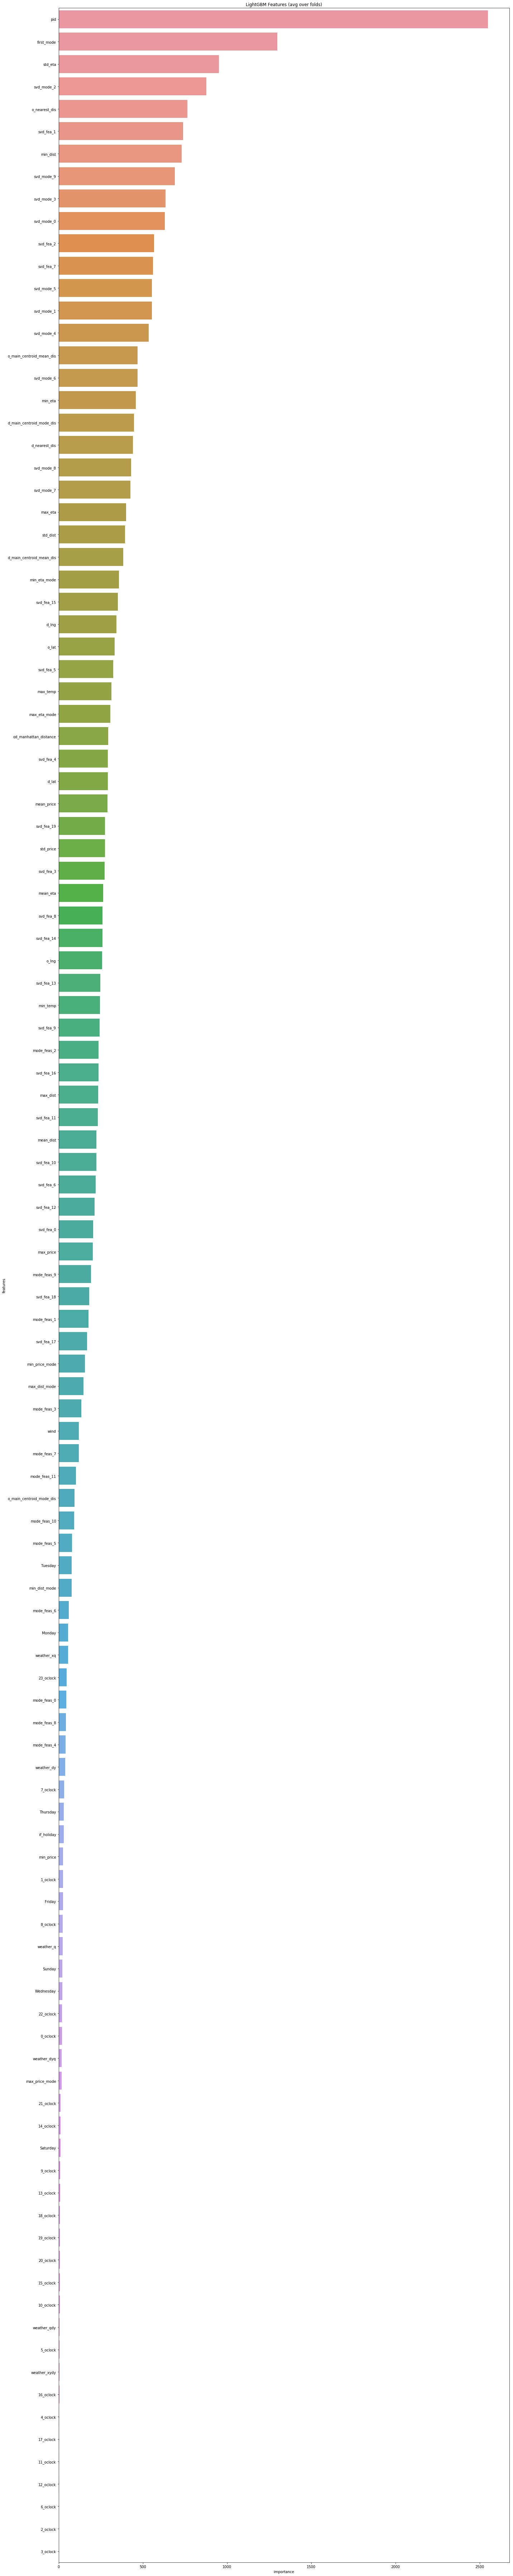

In [142]:
plt.figure(figsize=(20, 100))
sns.barplot(x="importance",
            y="features",
            data=imp)
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()

# Predict

In [143]:
pred = lgb_model.predict(valid_x)
df_analysis = pd.DataFrame()
df_analysis['sid'] = data[valid_index]['sid']
df_analysis['label'] = valid_y.values
df_analysis['pred'] = pred
df_analysis['label'] = df_analysis['label'].astype(int)
dic_ = df_analysis['label'].value_counts(normalize=True)

score_df = pd.DataFrame(
    columns=['class_id', 'counts*f1_score', 'f1_score', 'precision', 'recall'])


def get_weighted_fscore(y_pred, y_true):
    f_score = 0
    for i in range(12):
        yt = y_true == i
        yp = y_pred == i
        f_score += dic_[i] * f1_score(y_true=yt, y_pred=yp)
        score_df.loc[i] = [i, dic_[i], f1_score(y_true=yt, y_pred=yp), precision_score(
            y_true=yt, y_pred=yp), recall_score(y_true=yt, y_pred=yp)]
    print(f_score)
    return score_df


score_df = get_weighted_fscore(
    y_true=df_analysis['label'], y_pred=df_analysis['pred'])
score_df

# 0.7095882458513125
# 0.6881122981481186
# 0.6876586015532968
# 0.6877299824446942

0.6823243264997222


,class_id,counts*f1_score,f1_score,precision,recall
0,0.0,0.087414,0.336854,0.766667,0.215846
1,1.0,0.144617,0.681673,0.604592,0.781281
2,2.0,0.313324,0.899842,0.845629,0.961482
3,3.0,0.044598,0.055968,0.597122,0.029360
4,4.0,0.024453,0.012796,0.769231,0.006452
5,5.0,0.097574,0.840286,0.773308,0.919968
6,6.0,0.019893,0.137395,0.375887,0.084060
7,7.0,0.177920,0.786048,0.700028,0.896170
8,8.0,0.004559,0.238193,0.292929,0.200692
9,9.0,0.049931,0.507828,0.589883,0.445814


In [32]:
score_df['counts*f1_score'].sum()

1.0

In [144]:
all_train_x = data[data.req_time <
                   '2018-12-01'][feature].reset_index(drop=True)
all_train_y = data[data.req_time <
                   '2018-12-01'].click_mode.reset_index(drop=True)
print(lgb_model.best_iteration_)
lgb_model.n_estimators = lgb_model.best_iteration_
lgb_model.fit(all_train_x, all_train_y, categorical_feature=cate_feature)
print('fit over')
result = pd.DataFrame()
result['sid'] = data[test_index]['sid']
result['recommend_mode'] = lgb_model.predict(test_x)
result['recommend_mode'] = result['recommend_mode'].astype(int)
print(len(result))
print(result['recommend_mode'].value_counts())

39
fit over
94358
2     34460
7     22495
1     18489
5     10968
10     3280
0      1938
9      1739
11      357
8       244
6       195
3       181
4        12
Name: recommend_mode, dtype: int64


In [48]:
result[['sid', 'recommend_mode']].to_csv(
    project_path + 'Data/submit.csv', index=False)